# Set up

## Package Loading

In [1]:
import pandas as pd
import numpy as np
import itertools
!pip install emoji
import emoji
import re
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from sklearn.utils.multiclass import unique_labels
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, make_scorer
import matplotlib.pyplot as plt
import time
import joblib

from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 175 kB 5.1 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=732bedda843c1f04242e881f53f0a8e0f5ca2b3dc557b6a76f6c0a438053f81c
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Mounted at /content/drive


## Set Up paths

In [18]:
# Parent paths
google_path = '/content/drive/My Drive/'
local_path = '/home/v.zevallosm/'
parent_path = google_path

#Specific paths
path_train = parent_path+"team project/data set/dataset search/Twitter Sentiment Analysis/train_tweet.csv" 
path_test = parent_path+"team project/data set/dataset search/Twitter Sentiment Analysis/test_tweet.csv" 
path_proprocessed = parent_path+"team project/codes/models/with_lemmatization_nltk/text_without_sw.csv"

path_hyperparameters_sgd = parent_path+"team project/codes/models/best parameters/sgd.csv"
path_hyperparameters_svm = parent_path+"team project/codes/models/best parameters/svm.csv"
path_hyperparameters_et = parent_path+"team project/codes/models/best parameters/et.csv"
path_hyperparameters_rf = parent_path+"team project/codes/models/best parameters/rf.csv"
path_hyperparameters_nb = parent_path+"team project/codes/models/with_lemmatization_nltk/nb.csv"
path_hyperparameters_knn = parent_path+"team project/codes/models/best parameters/knn.csv"
path_hyperparameters_lr = parent_path+"team project/codes/models/best parameters/lr.csv"
path_hyperparameters_dt = parent_path+"team project/codes/models/best parameters/dt.csv"

path_best_parameters_sgd = parent_path+"team project/codes/models/sgd.pkl"
path_best_parameters_svm = parent_path+"team project/codes/models/svm.pkl"
path_best_parameters_et = parent_path+"team project/codes/models/et.pkl"
path_best_parameters_rf = parent_path+"team project/codes/models/rf.pkl"
path_best_parameters_nb = parent_path+"team project/codes/models/with_lemmatization_nltk/nb.pkl"
path_best_parameters_knn = parent_path+"team project/codes/models/knn.pkl"
path_best_parameters_lr = parent_path+"team project/codes/models/lr.pkl"
path_best_parameters_dt = parent_path+"team project/codes/models/dt.pkl"

## Set Up Functions

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Data Exploration

In [4]:
train = pd.read_csv(path_train)
test = pd.read_csv(path_test)

In [5]:
print(train.shape)
print(test.shape)
print()
print(train.label.unique())
print(train.isnull().any())
print(test.isnull().any())
train.head()

(31962, 3)
(17197, 2)

[0 1]
id       False
label    False
tweet    False
dtype: bool
id       False
tweet    False
dtype: bool


,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


# Data Preprocessing

## Data Cleansing

In [6]:
content = train['tweet']
label = train['label']

In [7]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
 
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) 

list_tokens = []
# for every tweet tokenize
for text in content:
  list_stem = []
  word_tokens = word_tokenize(text)
  for word in word_tokens:
    word_tokens = lemmatizer.lemmatize(word)
    list_stem.append(word_tokens)
  list_tokens.append(list_stem)

list_all_filtered = []
for tokens in list_tokens: 
  list_filtered = [] 
  for word in tokens: 
      if word not in stop_words: 
          list_filtered.append(word) 
  list_all_filtered.append(list_filtered)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [8]:
list_text = []
for tokens in list_all_filtered:
  sentence = ' '.join(tokens)
  list_text.append(sentence)

In [9]:
def dataCleansing(data):

    # Convert text to lowercase
    data = data.lower()
    
    #Removing URLs
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    data = url_pattern.sub(r'', data)

    #Remove non-english words
    data =  re.sub("[^a-z]+", " ",data)
        
    return data

preprocessed_text = []
for i in range(len(list_text)):
    preprocessed_text.append(dataCleansing(list_text[i]))
preprocessed_text[:5]

[' user father dysfunctional selfish drag kid dysfunction run',
 ' user user thanks lyft credit ca n t use cause n t offer wheelchair van pdx disapointed getthanked',
 'bihday majesty',
 ' model love u take u time ur ',
 'factsguide society motivation']

## Tokenization 

In [10]:
# preprocessed text without stopwords saved in csv
text_without_sw = pd.DataFrame(preprocessed_text,columns=['text'])
text_without_sw = pd.concat([label,text_without_sw], axis=1)
text_without_sw.to_csv('text_without_sw.csv',index=False)
text_without_sw.head()

,label,text
0,0,user father dysfunctional selfish drag kid dy...
1,0,user user thanks lyft credit ca n t use cause...
2,0,bihday majesty
3,0,model love u take u time ur
4,0,factsguide society motivation


# Balance Dataset

In [13]:
# loading preprocessd data
df = pd.read_csv(path_proprocessed)
df = df[df['text'].apply(lambda x: isinstance(x, str))] # Temporal solution

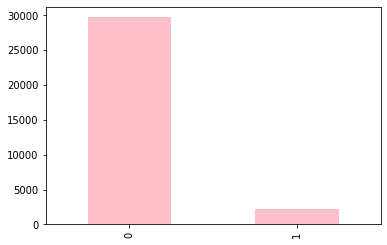

In [14]:
df['label'].value_counts().plot.bar(color = 'pink', figsize = (6, 4))

## Train, Validation, Test Split

In [15]:
# split
x_train, x_test = train_test_split(df, test_size=0.2, random_state = 453, stratify=df['label'])
x_test, x_valid = train_test_split(x_test, test_size=0.5 , random_state = 453, stratify= x_test['label'])

y_train = x_train['label']
x_train = x_train['text']
#del x_train['label']

y_test = x_test['label']
x_test = x_test['text']
#del x_test['label']

y_valid = x_valid['label']
x_valid = x_valid['text']
#del x_valid['label']

print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)
display(x_train)

(25568,)
(3197,)
(3196,)


21748    n healthy man bridge gap life death live s dea...
6583     pickin crow playing tn fitness spa june th p m...
5968      eid sm poetry sm masla e bewafa jaun elia fun...
23040    treat customer way news treat secret itzeebitz...
9045      flying free my selfporait fly musicinmyhead d...
                               ...                        
1340     look like katsubi ha closed miranda hope m wro...
3408                 wa n t aware facebook wa legislature 
16317    dad wa best friend greatest role model wa amaz...
15752                                     re almost think 
11977    cute walk evening walk cute well somerset phot...
Name: text, Length: 25568, dtype: object

# Training Models in a Pipeline

## Pipeline Set Up

In [16]:
# define transforms
vectorizer = TfidfVectorizer()
sampling = RandomUnderSampler(random_state=453)

# define the scoring function
f1 = make_scorer(f1_score)

# set up cross validation configuration
cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)


## Naïve Bayes

In [19]:
# Optimize parameters for NB Classifier
from sklearn.naive_bayes import MultinomialNB
estimator = MultinomialNB()

# Define grid of posible hyperparamters values 
parameters = {
    'vectorizer__max_df': [0.25, 0.5, 0.75, 1.0],
    'vectorizer__smooth_idf': (True, False),
    'vectorizer__norm': ('l1', 'l2', None),
    'estimator__alpha': [ 0.0001, 0.001, 0.01, 0.1, 1, 10],
}

# Create a pipeline
pipeline = Pipeline([ ('vectorizer', vectorizer), ('balancing', sampling), ('estimator', estimator) ])
print(pipeline)

# Hyperparameter optimization with Grid Search
start_time = time.time()
grid_search_estimator = GridSearchCV(pipeline, parameters, scoring=f1, cv=cv, return_train_score=False, n_jobs=-1, verbose=2)
grid_search_estimator.fit(x_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))
print("Multinomial NBClassifier: {}% F1-score for class 'hate-speech' with parameters {}".format(grid_search_estimator.best_score_ * 100, grid_search_estimator.best_params_))

# Save hyperparameter optmization results
df_hyper = pd.DataFrame(grid_search_estimator.cv_results_)
df_hyper.to_csv(path_hyperparameters_nb, index=False)

# Save best hyperparameters values
joblib.dump(grid_search_estimator.best_params_, path_best_parameters_nb, compress = 1) # Only best parameters


Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('balancing', RandomUnderSampler(random_state=453)),
                ('estimator', MultinomialNB())])
Fitting 8 folds for each of 144 candidates, totalling 1152 fits
--- 338.99940848350525 seconds ---
Multinomial NBClassifier: 46.28100802912446% F1-score for class 'hate-speech' with parameters {'estimator__alpha': 1, 'vectorizer__max_df': 0.25, 'vectorizer__norm': 'l2', 'vectorizer__smooth_idf': True}


['/content/drive/My Drive/team project/codes/models/with_lemmatization_nltk/nb.pkl']

              precision    recall  f1-score   support

           0       0.99      0.84      0.91      2972
           1       0.29      0.88      0.44       224

    accuracy                           0.84      3196
   macro avg       0.64      0.86      0.67      3196
weighted avg       0.94      0.84      0.88      3196



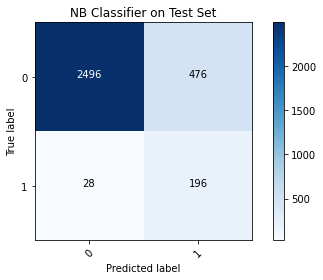

In [20]:
prediction = grid_search_estimator.predict(x_test)
cm = confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes = unique_labels(y_test), title = "NB Classifier on Test Set")
print(classification_report(y_test, prediction))

# New Section